In [17]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
from muon import atac as ac


sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [2]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#aec7e8', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#ffbb78', 'Fev+ Delta,1':'#98df8a',
        'Fev+ Delta,2': '#17becf', 'Ngn3 high cycling': '#aec7e8',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}

In [3]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:
output_dir = "."

In [5]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [6]:
adata.uns["celltype_colors"] = [color_dict[ct] for ct in adata.obs["celltype"].cat.categories]

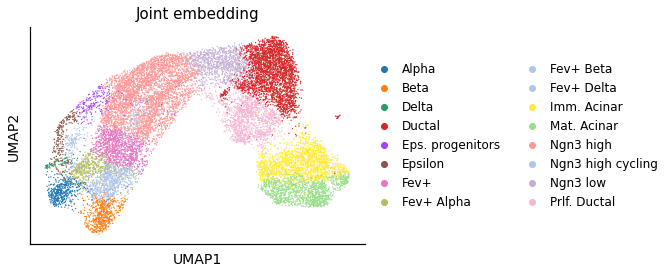

In [7]:
fig = sc.pl.embedding(adata, basis="umap", color=["celltype"], title="Joint embedding", show=False)

In [9]:
adata_gex = adata[:,adata.var["modality"]=="GEX"]

In [32]:
adata_atac = adata[:,adata.var["modality"]=="ATAC"].copy()

In [12]:
sc.pp.normalize_total(adata_gex)
sc.pp.pca(adata_gex)

/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.tl.dendrogram(adata_gex, groupby="celltype")

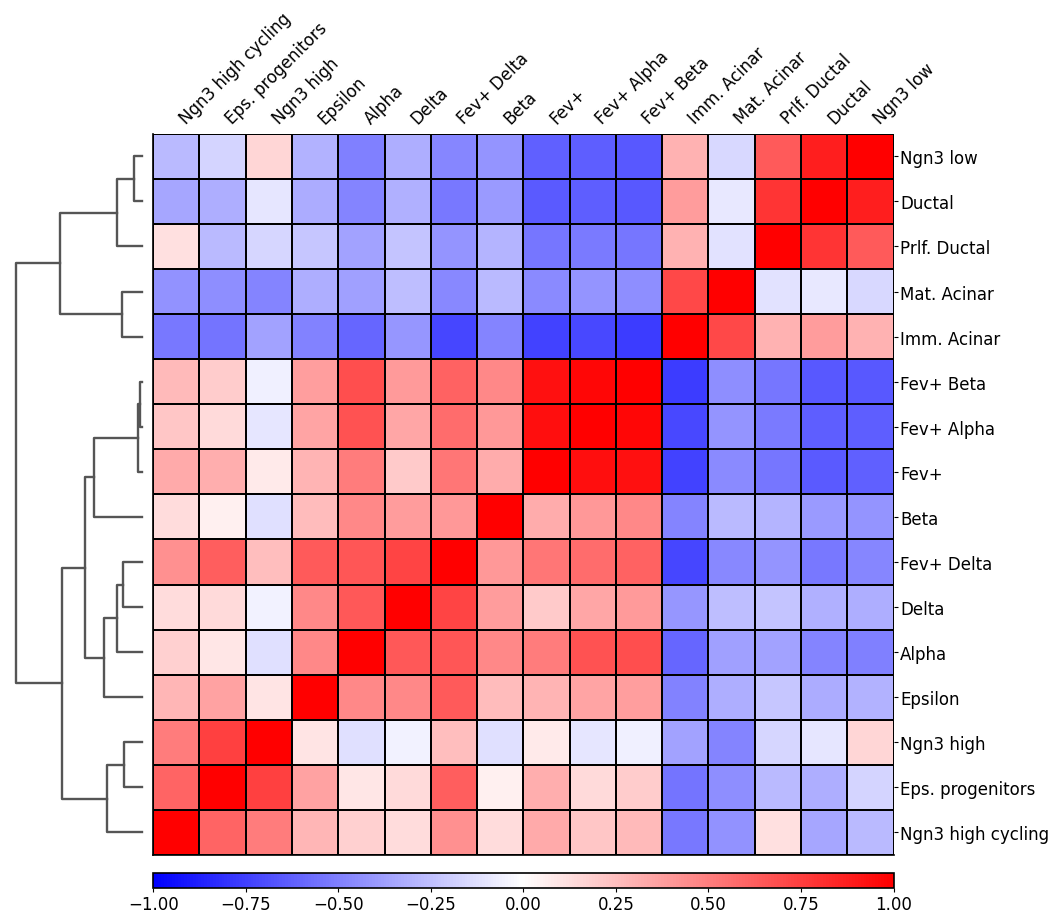

In [20]:
sc.pl.correlation_matrix(adata_gex, "celltype")

In [33]:
ac.pp.tfidf(adata_atac, scale_factor=1e4)

In [34]:
sc.pp.normalize_per_cell(adata_atac, counts_per_cell_after=1e4)
sc.pp.log1p(adata_atac)

In [35]:
ac.tl.lsi(adata_atac, n_comps=30)

In [36]:
depth_corr = [np.corrcoef(adata_atac.obsm["X_lsi"][:,i], adata_atac.obs["nCount_ATAC"])[1,0] for i in range(adata_atac.obsm["X_lsi"].shape[1])]

In [37]:
comps_to_remove = np.where(np.abs(depth_corr) > 0.4)[0]
comps_to_remove

array([0, 4])

In [38]:
subset = list(set(range(adata_atac.obsm["X_lsi"].shape[1])) - set(comps_to_remove))

In [39]:
adata_atac.obsm['X_lsi'] = adata_atac.obsm['X_lsi'][:,subset]

In [40]:
sc.tl.dendrogram(adata_atac, groupby="celltype", use_rep="X_lsi")

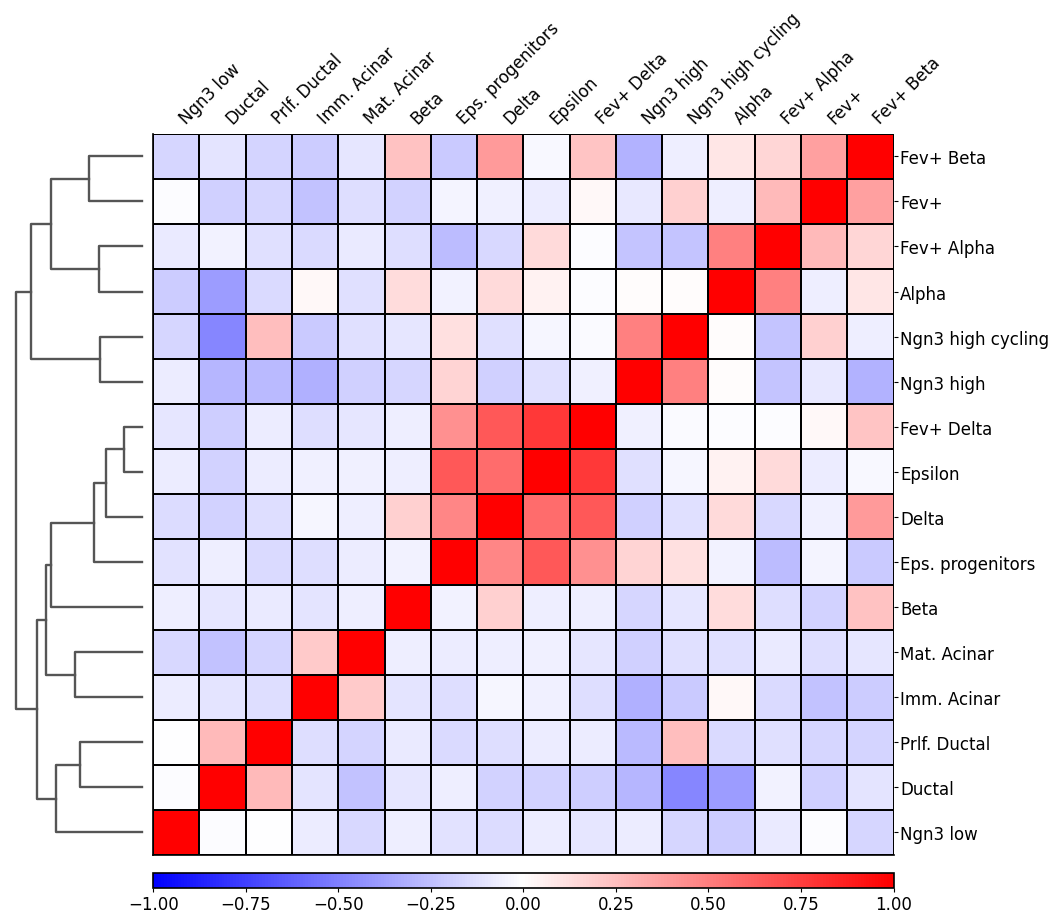

In [41]:
sc.pl.correlation_matrix(adata_atac, "celltype")